In [116]:
import h5py
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
%matplotlib notebook
from mpl_toolkits import mplot3d 

In [117]:
filepath = "/Users/rahulmv/Desktop/Dominoes/pilot_dominoes_0mid_d3chairs_o1plants_tdwroom_0124.hdf5"
f = h5py.File(filepath)
name = filepath.split('/')[-1].split('.')[0]

In [118]:
def get_ax(fig):
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.view_init(elev=100., azim=-90)
    return ax
def plot_box(pts, colors, close=False):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.view_init(elev=100., azim=-90)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], c=colors)
    return fig
#     plt.close(fig)
# plot_box(vertices_orig, colors=[[0, 0, 1]])

def get_transformed_pts(pts, frame, obj_id):
    frame = str(frame).zfill(4)
    
#     print(frame)
    
    rotations_0 = np.array(f['frames'][frame]['objects']['rotations'][obj_id])
    positions_0 = np.array(f['frames'][frame]['objects']['positions'][obj_id])
    
    rot = R.from_quat(rotations_0).as_matrix()
    trans = positions_0
    transformed_pts = np.matmul(rot, pts.T).T + np.expand_dims(trans, axis=0)
    
    return transformed_pts

import colorsys 
 
def HSVToRGB(h, s, v): 
    (r, g, b) = colorsys.hsv_to_rgb(h, s, v) 
    return (int(255*r), int(255*g), int(255*b)) 
 
def getDistinctColors(n): 
    huePartition = 1.0 / (n + 1) 
    return np.array(list((HSVToRGB(huePartition * value, .4, .5) for value in range(0, n))))/255.0


def get_vertices_scaled(obj_id):
    
    vertices_orig = np.array(f['static']['mesh']['vertices_' + str(obj_id)])

    scales = f["static"]["scale"][:]

    vertices_orig[:,0] *= scales[obj_id, 0]
    vertices_orig[:,1] *= scales[obj_id, 1]
    vertices_orig[:,2] *= scales[obj_id, 2]
    faces_orig = np.array(f['static']['mesh']['faces_' + str(obj_id)])
    
    return vertices_orig, faces_orig
        
    

<IPython.core.display.Javascript object>


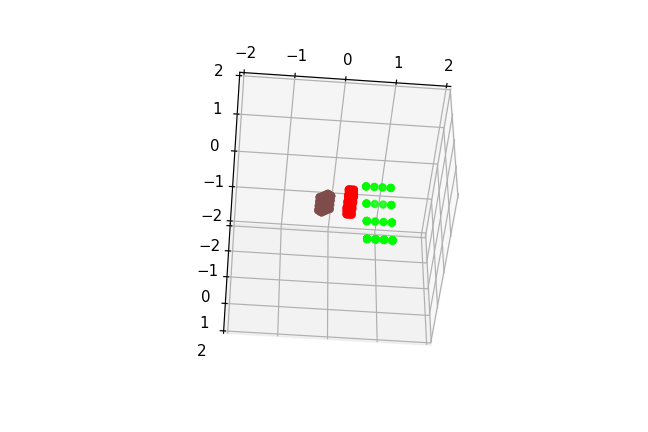

In [129]:
reject = np.array(f['static']['model_names']) != b'cube'

object_ids = np.array(f['static']['object_ids'])

colors = [[0, 1, 0], [1, 0, 0]]

colors += list(getDistinctColors(len(object_ids)-2))

#NOTE THE FIRST OBJECT IS ALWAYS THE PATIENT
frame_no = 0

%matplotlib notebook
%matplotlib notebook

all_imgs = []

for frame_no in range(len(f['frames'])):
    all_pts = []
    all_colors = []
    for obj_id in object_ids:
        obj_id = obj_id-1    
        if not reject[obj_id]:
            vertices_orig, faces_orig = get_vertices_scaled(obj_id)
            frame_pts = get_transformed_pts(vertices_orig, frame_no, obj_id)
            cs = np.stack([colors[obj_id]]*len(frame_pts), 0)
            all_pts.append(frame_pts)
            all_colors.append(cs)

    #     break

    all_pts = np.concatenate(all_pts, 0)
    all_colors = np.concatenate(all_colors, 0)

    fig = plot_box(all_pts, all_colors)
    
    break
    
    fig.savefig('temp.png')
    
    plt.close(fig)

    img = plt.imread('temp.png')
    
    all_imgs.append(img)

# frame_50_pts = get_transformed_pts(vertices_orig, 150, obj_id)

In [120]:
def draw3DRectangle(ax, x1, y1, z1, x2, y2, z2):
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    # the Translate the datatwo sets of coordinates form the apposite diagonal points of a cuboid
    ax.plot([x1, x2], [y1, y1], [z1, z1], color='b') # | (up)
    ax.plot([x2, x2], [y1, y2], [z1, z1], color='b') # -->
    ax.plot([x2, x1], [y2, y2], [z1, z1], color='b') # | (down)
    ax.plot([x1, x1], [y2, y1], [z1, z1], color='b') # <--

    ax.plot([x1, x2], [y1, y1], [z2, z2], color='b') # | (up)
    ax.plot([x2, x2], [y1, y2], [z2, z2], color='b') # -->
    ax.plot([x2, x1], [y2, y2], [z2, z2], color='b') # | (down)
    ax.plot([x1, x1], [y2, y1], [z2, z2], color='b') # <--
    
    ax.plot([x1, x1], [y1, y1], [z1, z2], color='b') # | (up)
    ax.plot([x2, x2], [y2, y2], [z1, z2], color='b') # -->
    ax.plot([x1, x1], [y2, y2], [z1, z2], color='b') # | (down)
    ax.plot([x2, x2], [y1, y1], [z1, z2], color='b') # <--

In [121]:
x1, y1, z1 = vertices_orig.min(0)
x2, y2, z2 = vertices_orig.max(0)

<IPython.core.display.Javascript object>


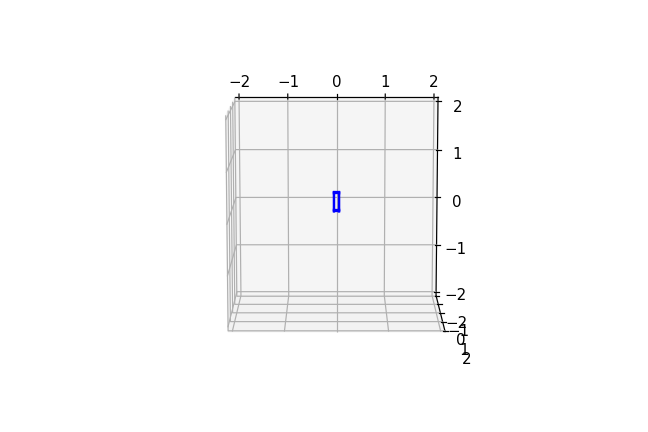

In [122]:
%matplotlib notebook
%matplotlib notebook
fig = plt.figure()
ax = get_ax(fig)
draw3DRectangle(ax, x1, y1, z1, x2, y2, z2)

In [124]:
import subprocess
import cv2
def write_video(file_path, frames, fps):
    """
    Writes frames to an mp4 video file
    :param file_path: Path to output video, must end with .mp4
    :param frames: List of PIL.Image objects
    :param fps: Desired frame rate
    """

    h, w = frames[0].shape[:2]
    fourcc = cv2.cv2.VideoWriter_fourcc(*"MJPG")# cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

    for frame in frames:
        writer.write((frame[:, :, :3]*255).astype('uint8'))

    writer.release() 

In [125]:
all_imgs[0].shape

(288, 432, 4)

In [126]:
write_video(name + '.avi', all_imgs, 30)

<IPython.core.display.Javascript object>


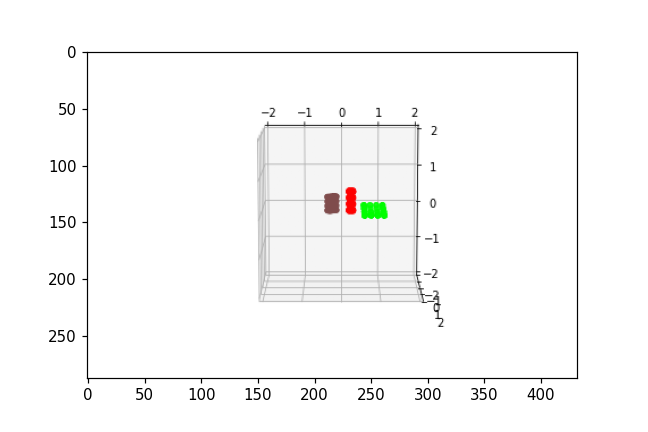

In [127]:
%matplotlib notebook
%matplotlib notebook
plt.figure()
plt.imshow(all_imgs[0])